<a href="https://colab.research.google.com/github/lionelsaxer/DLSS/blob/main/Final_Essay_DLSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Essay DLSS Code

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from collections import Counter
from operator import itemgetter
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [25]:
# Import data set
df_vdem = pd.read_csv("/content/drive/MyDrive/V-Dem-CY-Full+Others-v13.csv",
                      usecols=["v2eltrnout", "country_name", "year",
                               "v2elvaptrn", "e_wb_pop", "v2elcomvot",
                               "v2elpubfin", "v2ellovtlg", "v2ellovtsm",
                               "v2elparlel"])

In [26]:
df_vdem = df_vdem[["v2eltrnout", "country_name", "year", "v2elvaptrn",
                    "e_wb_pop", "v2elcomvot", "v2elpubfin", "v2ellovtlg",
                    "v2ellovtsm", "v2elparlel"]]

In [27]:
df_vdem.head()

,v2eltrnout,country_name,year,v2elvaptrn,e_wb_pop,v2elcomvot,v2elpubfin,v2ellovtlg,v2ellovtsm,v2elparlel
0,NaN,Mexico,1789,NaN,NaN,NaN,-2.176,NaN,NaN,NaN
1,NaN,Mexico,1790,NaN,NaN,NaN,-2.176,NaN,NaN,NaN
2,NaN,Mexico,1791,NaN,NaN,NaN,-2.176,NaN,NaN,NaN
3,NaN,Mexico,1792,NaN,NaN,NaN,-2.176,NaN,NaN,NaN
4,NaN,Mexico,1793,NaN,NaN,NaN,-2.176,NaN,NaN,NaN


In [28]:
df_vdem[["v2eltrnout", "v2elvaptrn"]].isna().sum()

v2eltrnout    24334
v2elvaptrn    25167
dtype: int64

In [29]:
# Remove VAP turnout
df_vdem = df_vdem.drop("v2elvaptrn", axis=1)

In [30]:
# Look at data for Switzerland
df_vdem_Switzerland = df_vdem.loc[df_vdem["country_name"]=="Switzerland"]
df_vdem_Switzerland = df_vdem_Switzerland.dropna()

In [31]:
df_vdem_Switzerland

,v2eltrnout,country_name,year,e_wb_pop,v2elcomvot,v2elpubfin,v2ellovtlg,v2ellovtsm,v2elparlel
756,64.46,Switzerland,1963,5694247.0,0.0,-2.215,26.60,23.9,1.0
760,63.76,Switzerland,1967,5991785.0,0.0,-2.215,23.50,23.2,1.0
764,56.36,Switzerland,1971,6213399.0,0.0,-2.215,22.90,21.7,1.0
768,52.39,Switzerland,1975,6338632.0,0.0,-2.215,24.90,22.2,1.0
772,48.06,Switzerland,1979,6294365.0,0.0,-2.215,24.40,24.0,1.0
776,48.91,Switzerland,1983,6418773.0,0.0,-2.215,23.30,22.8,1.0
780,47.48,Switzerland,1987,6545106.0,0.0,-2.215,22.90,19.6,1.0
784,46.04,Switzerland,1991,6799978.0,0.0,-2.215,21.00,18.5,1.0
788,42.25,Switzerland,1995,7040687.0,0.0,-1.979,21.80,20.2,1.0
792,43.22,Switzerland,1999,7143991.0,0.0,-1.979,22.60,22.5,1.0


In [32]:
# Pre-processing
df_vdem = df_vdem.dropna() # remove missing values
c = Counter(df_vdem.country_name)
min_key, min_count = min(c.items(), key=itemgetter(1))
print(min_key, min_count)

Haiti 1


In [12]:
# Let's see how many countries occur >= 3 times in the data set
print("Total number of countries:", len(df_vdem.country_name.unique()))
print(
    "Number of countries occuring at least 3 times:",
    len(
    df_vdem[df_vdem.groupby('country_name')['country_name']
            .transform('size') >= 3]
    .country_name.unique()
    )
  )

Total number of countries: 156
Number of countries occuring at least 3 times: 143


In [33]:
df_vdem.shape

(1475, 9)

In [34]:
def merge(data1, data2):
  x1, y1 = data1
  x2, y2 = data2
  return tf.concat([x1, x2], axis=-1), tf.concat([y1, y2], axis=-1)

In [43]:
k=1
for country in df_vdem.country_name.unique():
  df_h=df_vdem[df_vdem.country_name==country]
  if df_h.shape[0]>15:
    #removing the country name
    print(country)
    df_h=df_h[["v2eltrnout", "e_wb_pop", "v2elcomvot",\
        "v2elpubfin", "v2elparlel", "v2ellovtlg", "v2ellovtsm"]]

    raw_data=df_h.to_numpy()
    num_train_samples = int(0.5 * len(raw_data))
    num_val_samples = int(0.25 * len(raw_data))
    num_test_samples = len(raw_data) - num_train_samples - num_val_samples

    # normalize data
    mean = raw_data[:num_train_samples].mean(axis=0)
    raw_data -= mean
    std = raw_data[:num_train_samples].std(axis=0)
    raw_data /= (std + 1e-9)

    sampling_rate = 1 # every election
    sequence_length = 3 # use last 3 elections to predict
    delay = sampling_rate * (sequence_length - 1)
    batch_size = 3
    #index to predict
    targets0=pd.DataFrame(raw_data)[0].to_numpy()
  try:
    if k==1:
      train_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=0,
          end_index=num_train_samples)

      val_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=num_train_samples,
          end_index=num_train_samples + num_val_samples - 1)

      test_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=num_train_samples + num_val_samples - 1)
    else:
        train_dataset2 = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=0,
          end_index=num_train_samples)

        val_dataset2 = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=targets0[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=True,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples - 1)

        test_dataset2 = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=targets0[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=True,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples - 1)
        k=2


        train_dataset = tf.data.Dataset.zip((train_dataset, train_dataset2)).map(merge)
        val_dataset = tf.data.Dataset.zip((val_dataset, val_dataset2)).map(merge)
        test_dataset = tf.data.Dataset.zip((test_dataset, test_dataset2)).map(merge)

  except:
    k=k+1

Mexico
Sweden
Japan
Colombia
United States of America
Portugal
Canada
Australia
Germany
Ireland
Netherlands
Austria
Belgium
Bulgaria
Denmark
Finland
Greece
Iceland
Israel
New Zealand
Norway


In [38]:
targets0

array([79.07, 85.43, 83.84, 80.24, 82.89, 81.99, 84.03, 83.16, 75.85,
       78.33, 75.48, 77.44, 76.37, 78.23, 78.22, 77.17])

In [42]:
for x, y in test_dataset:
  print(x.shape, y.shape)

(3, 3, 7) (3,)


In [37]:
#Naive Baseline from the Book github
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] #* std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4513675.52
Test MAE: 5079544.77


In [ ]:
# Estimate a simple, densely connected baseline
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(128)(inputs)
outputs = layers.Dense(1)(x) # predicting turnout
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("vdem_baseline.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("vdem_baseline.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
2/2 [==============================] - 5s 900ms/step - loss: 0.4127 - mae: 0.5290 - val_loss: 12.7783 - val_mae: 3.5747
Epoch 2/20
2/2 [==============================] - 0s 97ms/step - loss: 0.3809 - mae: 0.5016 - val_loss: 12.3977 - val_mae: 3.5210
Epoch 3/20
2/2 [==============================] - 0s 63ms/step - loss: 0.3449 - mae: 0.4764 - val_loss: 12.0220 - val_mae: 3.4673
Epoch 4/20
2/2 [==============================] - 0s 65ms/step - loss: 0.3091 - mae: 0.4538 - val_loss: 11.7713 - val_mae: 3.4309
Epoch 5/20
2/2 [==============================] - 0s 97ms/step - loss: 0.2750 - mae: 0.4318 - val_loss: 11.5290 - val_mae: 3.3954
Epoch 6/20
2/2 [==============================] - 0s 96ms/step - loss: 0.2620 - mae: 0.4440 - val_loss: 11.2372 - val_mae: 3.3522
Epoch 7/20
2/2 [==============================] - 0s 101ms/step - loss: 0.2413 - mae: 0.4138 - val_loss: 11.0408 - val_mae: 3.3228
Epoch 8/20
2/2 [==============================] - 0s 106ms/step - loss: 0.2108 - mae: 0.

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               69632     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


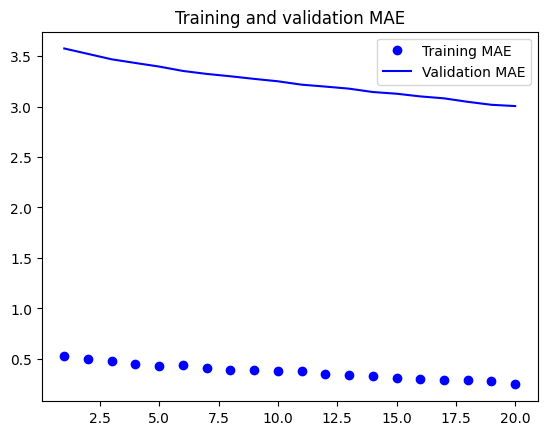

In [ ]:
# Plot MAE for training and validation data
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# Dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("vdem_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)